In [1]:
import sys
sys.path.append("..")

from vizutils import plot_comparison

## PBNN-8-8-8-8

### SILU


Final values (mean ± std):

PBNN (0, 4):
  RMSE: 0.6879 ± 0.0163
  NLPD: 1.0647 ± 0.0232
  COVERAGE: 0.9659 ± 0.0076

PBNN (1, 4):
  RMSE: 0.7391 ± 0.0262
  NLPD: 1.1312 ± 0.0439
  COVERAGE: 0.9187 ± 0.0087

PBNN (2, 4):
  RMSE: 0.7441 ± 0.0141
  NLPD: 1.2116 ± 0.0470
  COVERAGE: 0.8758 ± 0.0145

PBNN (3, 4):
  RMSE: 0.8138 ± 0.0236
  NLPD: 1.3482 ± 0.0258
  COVERAGE: 0.8641 ± 0.0115

Full BNN:
  RMSE: 0.6439 ± 0.0267
  NLPD: 0.9847 ± 0.0283
  COVERAGE: 0.9659 ± 0.0135


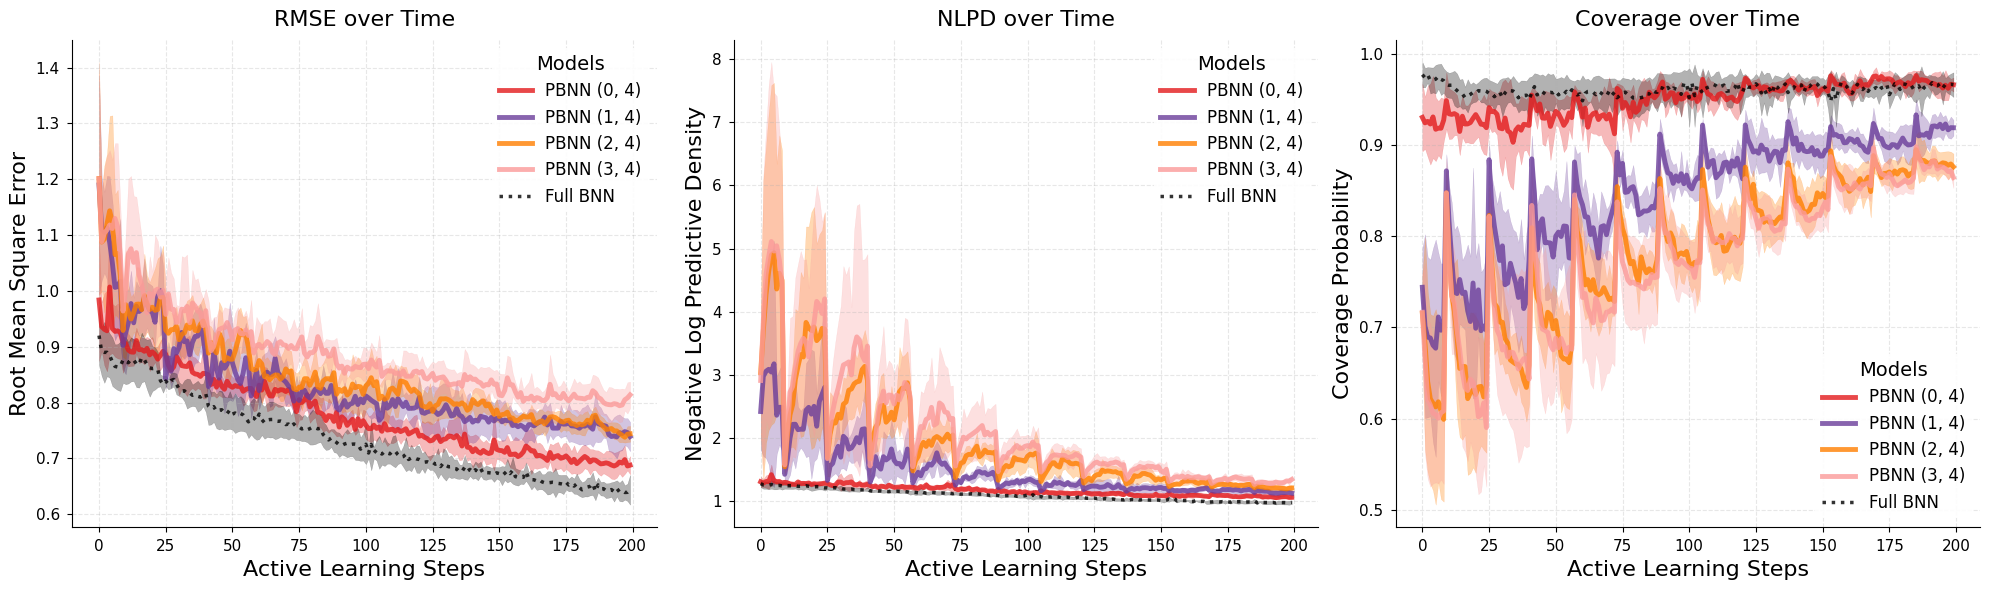

In [2]:
pbnn_files = [
    'results/pbnn8888/esol_probdense0-dense4_steps200_epochs2000_lr0.005_20241207_015431.pkl',
    'results/pbnn8888/esol_probdense1-dense4_steps200_epochs2000_lr0.005_20241207_052815.pkl',
    'results/pbnn8888/esol_probdense2-dense4_steps200_epochs2000_lr0.005_20241207_080057.pkl',
    'results/pbnn8888/esol_probdense3-dense4_steps200_epochs2000_lr0.005_20241206_220527.pkl'
]

#detnn_file = 'results/detnn8888/detnn_silu_epochs2000_lr0.005_20241210_152819.pkl'
bnn_file = 'results/bnn8888/esol_steps200_20241211_194819.pkl'

plot_comparison(
    pbnn_files=pbnn_files,
    bnn_file=bnn_file,
    save_path='comparison_plot-pbnn8888-silu.png'
);

Compare with DKL:


Final values (mean ± std):

PBNN (0, 4):
  RMSE: 0.6879 ± 0.0163
  NLPD: 1.0647 ± 0.0232
  COVERAGE: 0.9659 ± 0.0076

DKL (latent=2, silu):
  RMSE: 0.7986 ± 0.0240
  NLPD: 1.2017 ± 0.0232
  COVERAGE: 0.9597 ± 0.0084


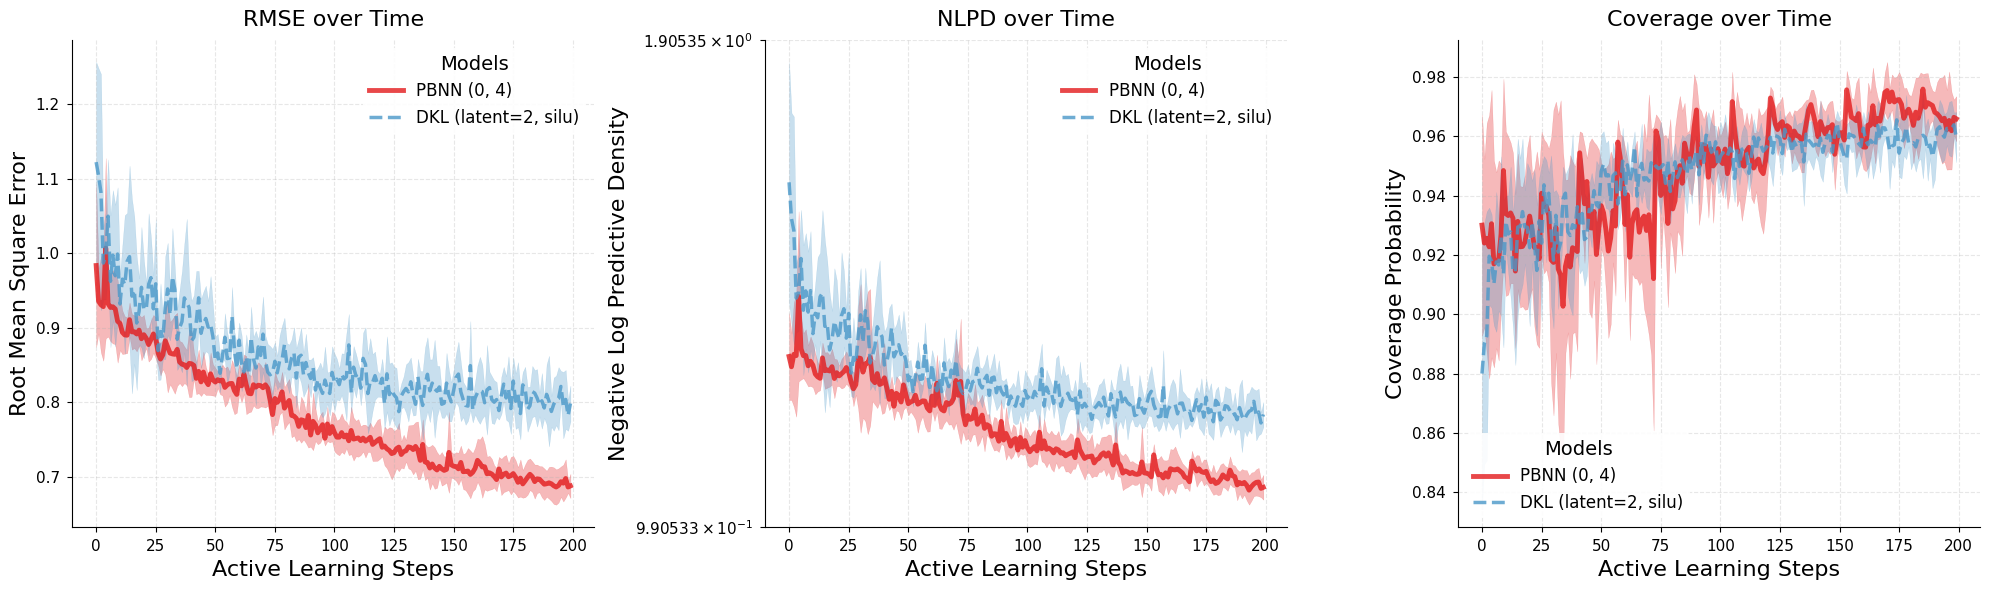

In [3]:
pbnn_files = [
    'results/pbnn8888/esol_probdense0-dense4_steps200_epochs2000_lr0.005_20241207_015431.pkl'
]

dkl_files = [
    'results/dkl8888/esol_dkl_latent2_silu_20241207_132112.pkl'
]

plot_comparison(
    pbnn_files=pbnn_files,
    dkl_files=dkl_files,
    save_path='comparison_plot-dkl-pbnn8888-silu.png'
);

Comparison with GP:


Final values (mean ± std):

PBNN (0, 4):
  RMSE: 0.6879 ± 0.0163
  NLPD: 1.0647 ± 0.0232
  COVERAGE: 0.9659 ± 0.0076

GP (matern52):
  RMSE: 0.6896 ± 0.0150
  NLPD: 1.0612 ± 0.0152
  COVERAGE: 0.9684 ± 0.0044


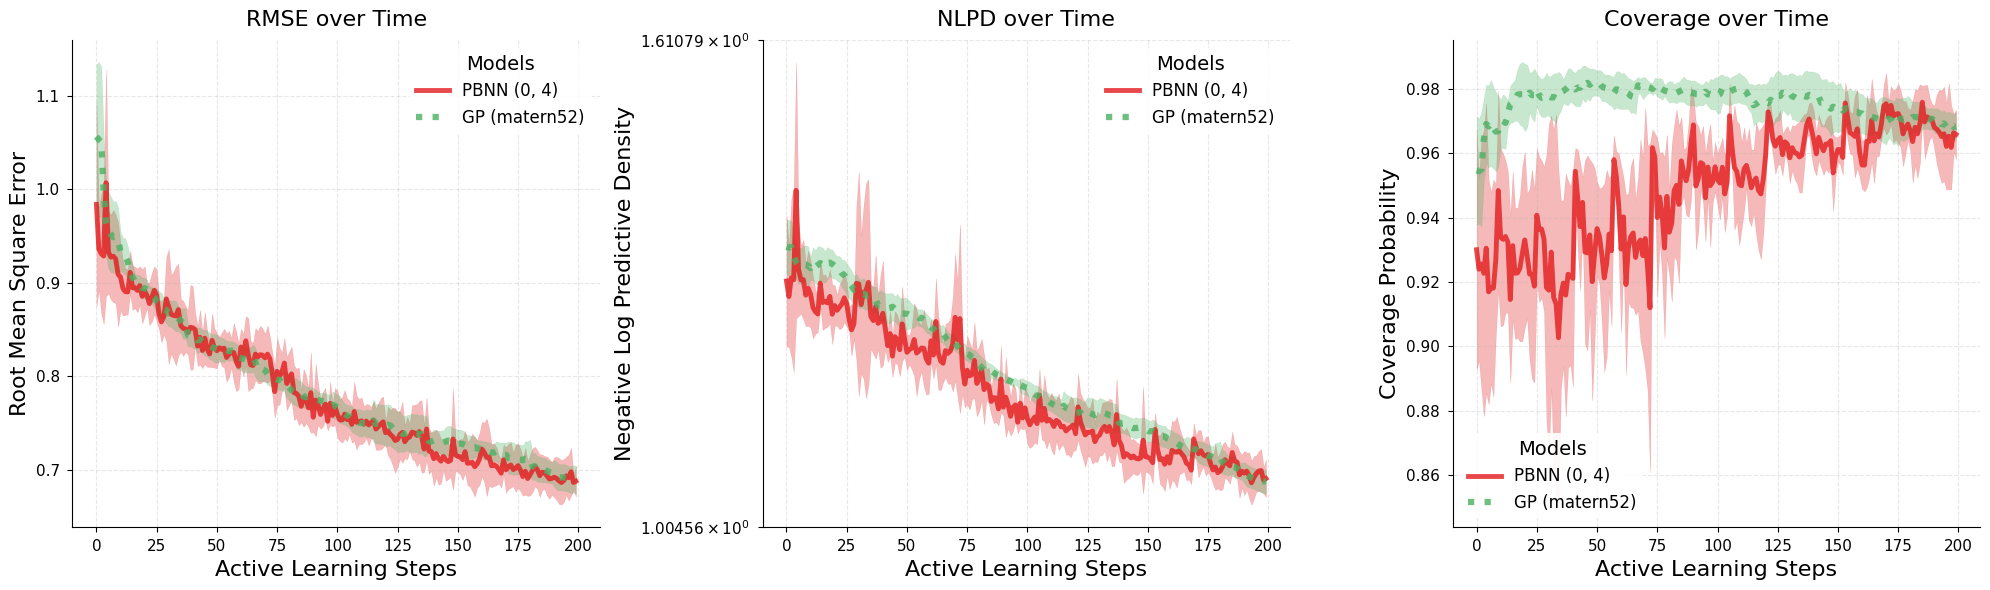

In [4]:
pbnn_files = [
    'results/pbnn8888/esol_probdense0-dense4_steps200_epochs2000_lr0.005_20241207_015431.pkl'
]

gp_files = [
    'results/gp/esol_gp_comparison_kernelmatern52_20241213_142511.pkl'
]

plot_comparison(
    pbnn_files=pbnn_files,
    gp_files=gp_files,
    save_path='comparison_plot-gp-pbnn8888-silu.png'
);